# NBA MVP Prediction Visualizations

## Import data/modules <a class="anchor" id="import-data"></a>


In [2]:
#essentials
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px

#tools/metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import shap

#modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#pandas show all columns
pd.set_option('display.max_columns', None)

### Read Data

In [8]:
data_path = os.path.dirname(os.getcwd()) + '/data' + '/master_table.csv'
print(data_path)
master_table = pd.read_csv(data_path)

/Users/dbtjdals/Desktop/nba_mvp_prediction/data/master_table.csv


In [9]:
master_table.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,year,team,W,W/L%,seed,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,147.0,221,0.665,82,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980,Los Angeles Lakers,60.0,0.732,1.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.8,2.4,7.2,7.3
1,2,Julius Erving,29,PHI,31.5,31.5,221,0.143,78,36.1,26.9,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,1980,Philadelphia 76ers,59.0,0.720,2.0,25.4,0.568,0.012,0.331,8.6,12.9,10.9,21.4,2.8,2.7,13.3,30.3,7.3,5.2,12.5,0.213,5.7,1.9,7.6,6.8
2,3,George Gervin,27,SAS,19.0,19.0,221,0.086,78,37.6,33.1,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,1980,San Antonio Spurs,41.0,0.500,4.5,24.0,0.587,0.053,0.306,5.7,8.9,7.3,11.0,1.6,1.4,10.3,31.7,9.3,1.3,10.6,0.173,5.5,-1.6,3.9,4.4
3,4,Larry Bird,23,BOS,15.0,15.0,221,0.068,82,36.0,21.3,10.4,4.5,1.7,0.6,0.474,0.406,0.836,11.2,0.182,1980,Boston Celtics,61.0,0.744,1.0,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0,14.0,25.3,5.6,5.6,11.2,0.182,3.0,1.5,4.5,4.8
4,5T,Tiny Archibald,31,BOS,2.0,2.0,221,0.009,80,35.8,14.1,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148,1980,Boston Celtics,61.0,0.744,1.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.4,-0.3,1.1,2.3


## Exploratory Data Analysis <a class="anchor" id="eda"></a>


### Correlation Matrix

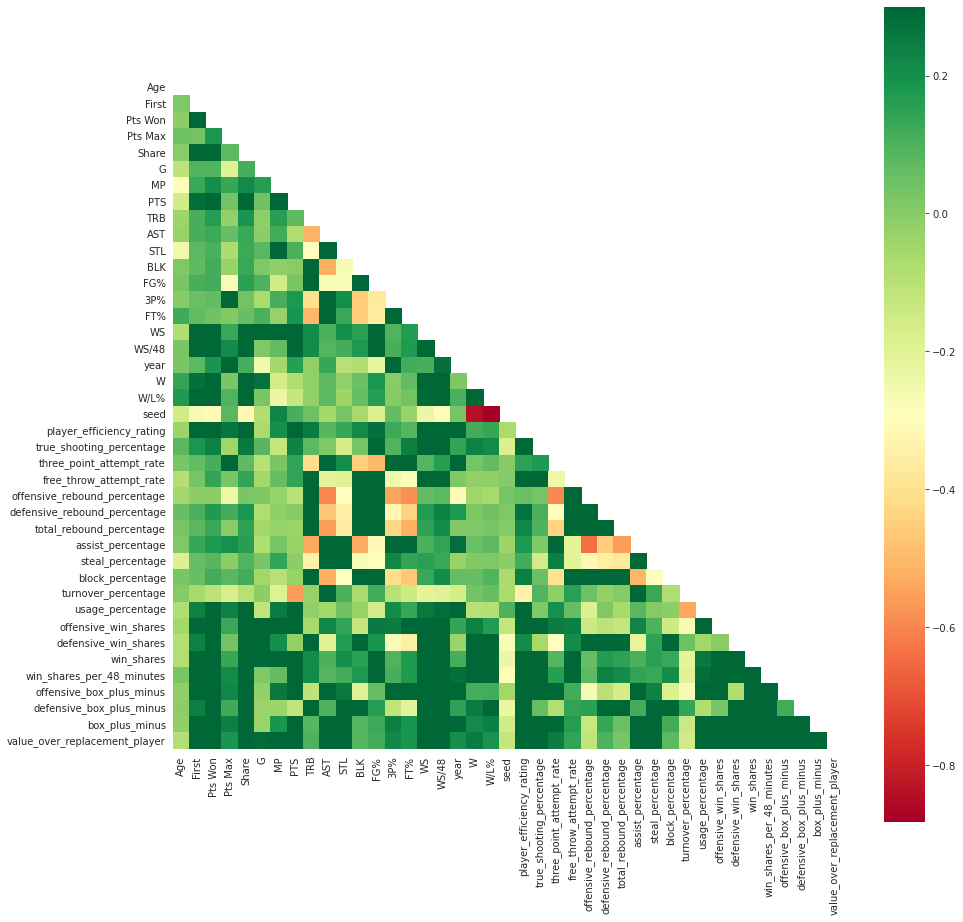

In [8]:
#correlations of each features
corr_matrix = master_table.corr()

#plot heat map
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True,cmap="RdYlGn")


### Visualize significant features vs. MVP Shares

In [3]:
username='dbtjdals'
api_key='32oRy7C1v1fbEU6pNbPx'

chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [5]:
def add_win_lose_col(df):
    rank_lst = []
    for i in list(df['Rank']):
        if i == '1':
            rank_lst.append('won')
        else:
            rank_lst.append('lost')
    master_table_rank = df.copy()
    master_table_rank['Win/Lose'] = rank_lst
    return master_table_rank

In [17]:
def show_feature_vs_share(feature, df):
    fig = px.scatter(data_frame = df,
               x=feature,
               y='Share',
               color='Win/Lose',
               color_discrete_sequence=['blue','gray'], 
               hover_data={
                   'Win/Lose': False,
                   'Player': True, 
                   'year': True,
                   'seed': True,
                   'W/L%': True, 
                   'W': True
                   
               })
    fig.update_layout(height=500,
                     title = f"{feature} vs. MVP share")
    return fig

In [22]:
features = ['win_shares', 
            'player_efficiency_rating',
            'value_over_replacement_player',
            'box_plus_minus',
            'offensive_box_plus_minus',
            'usage_percentage',
            'seed',
            'W',
            'W/L%',
            'PTS']

master_table_rank = add_win_lose_col(df=master_table)

fig_vorp = show_feature_vs_share(feature='value_over_replacement_player', df=master_table_rank)
fig_usage_percentage = show_feature_vs_share(feature='usage_percentage', df=master_table_rank)
fig_seed = show_feature_vs_share(feature='seed', df=master_table_rank)
fig_w = show_feature_vs_share(feature='W', df=master_table_rank)

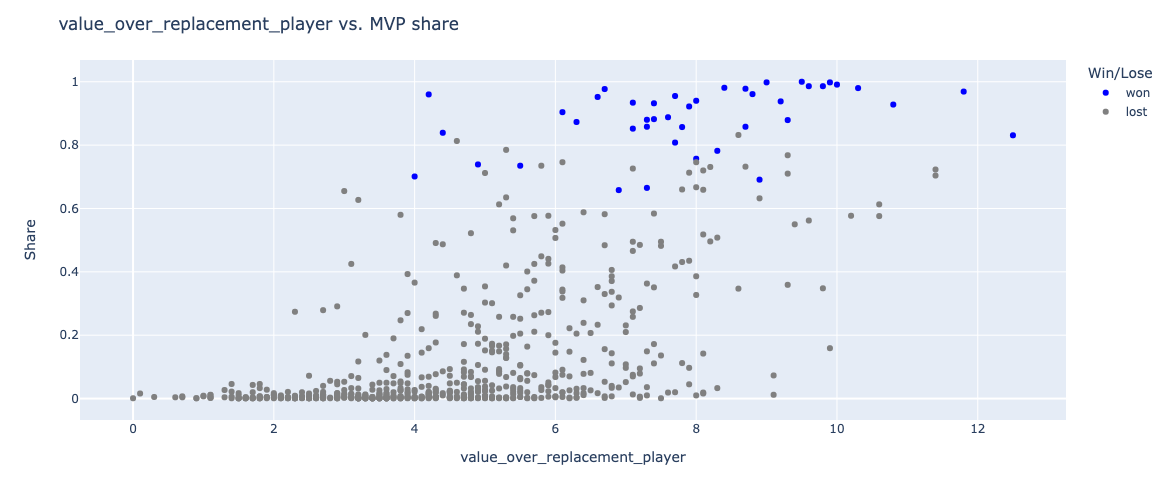

In [23]:
fig_vorp.show()

In [24]:
py.plot(fig_vorp, filename="nba_vorp_vs_mvp_shares", auto_open = True)


'https://plotly.com/~dbtjdals/1/'

In [25]:
py.plot(fig_seed, filename="nba_seed_vs_mvp_shares", auto_open = True)


'https://plotly.com/~dbtjdals/3/'

In [27]:
py.plot(fig_w, filename="nba_w_vs_mvp_shares", auto_open = True)


'https://plotly.com/~dbtjdals/7/'

In [26]:
py.plot(fig_usage_percentage, filename="nba_usage_vs_mvp_shares", auto_open = True)


'https://plotly.com/~dbtjdals/5/'